In [1]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from bgm import *
from sagan import *
from causal_model import *
from load_data import *

In [2]:
root_folder = 'dataset/celebA/'
img_dim = 64
batch_size = 128

cols = ['Young', 'Male', 'Bags_Under_Eyes', 'Chubby', 'Heavy_Makeup', 'Receding_Hairline', 'Gray_Hair']
num_label = len(cols)  

In [3]:
in_channels = 3
fc_size = 2048
latent_dim = 100

g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

A = torch.zeros((num_label, num_label))
A[0, 2:7] = 1
A[1, 4] = 1
A[1, 5] = 1
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)
checkpoint = torch.load('saved_model_attractive/bgm', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [4]:
file_name = "down_train_downsaple_minority_group"
df = pd.read_csv(f"dataset/celebA/{file_name}.csv").replace(-1,0)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,074083.jpg,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,186696.jpg,1,0,0,0,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
2,131285.jpg,0,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,1
3,023784.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,127290.jpg,0,0,0,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1


In [5]:
root_folder = 'dataset/celebA/'
dest_dir = 'synthetic_dataset/'


make_dir = lambda path : os.makedirs(path) if not os.path.exists(path) else 0
make_dir(dest_dir)
make_dir(dest_dir+"img")

0

In [6]:
y_name = 'Young'
attr_name = 'Male'

final_cols = [y_name, attr_name]

In [7]:
img_folder = f"{root_folder}img/img_align_celeba/"

In [8]:
img_ids_l = []
attr_l = []
label_l = []

In [9]:
def save_img(path, img):
    img.save(path)

In [10]:
row_idxs = []

In [11]:
for idx, row in df.iterrows():
    y = row[y_name]
    attr = row[attr_name]    
    label = row[cols]
    if (attr == 1 and y == 0) or (attr == 0 and y == 1):
        row_idxs.append(idx)

In [12]:
df_temp = df.iloc[row_idxs,:].reset_index(drop=True)
df_temp.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,136676.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,131553.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,090837.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,131609.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,066944.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
batch_size = 16

In [14]:
class ImageDataset(Dataset):
    def __init__(self, root_folder, df, transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/img_align_celeba/'
        
        self.attr = df
        self.image_names = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)
        return image, label

def get_dataloader(root_folder, df, img_dim=64, batch_size=32, cols = None):
    transform = Compose([CenterCrop(128),
                        Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    data = ImageDataset(root_folder=root_folder, df = df, transform=transform, cols = cols)
    dataloader = DataLoader(data, batch_size = batch_size, shuffle = True)
    return dataloader

In [15]:
df_1 = df_temp[(df_temp[attr_name] == 0) & (df_temp[y_name] == 1)].reset_index(drop=True)
df_1.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,074959.jpg,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,020729.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
2,168246.jpg,0,1,1,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
3,015828.jpg,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,000934.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [16]:
d1_loader = get_dataloader(root_folder, df_1)

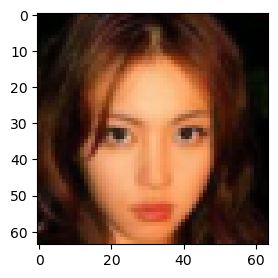

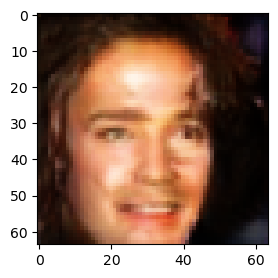

In [31]:
with torch.no_grad():
    for x, label in d1_loader:
        eps = model(x=x)
        eps[:, 0] = -2
        eps[:, 1] = 2
        label_z = model.prior(eps[:, :num_label])
        other_z = eps[:, num_label:]
        z = torch.cat([label_z, other_z], dim=1)
        new_img = model.decoder(z)
        new_img = np.transpose(new_img.cpu().numpy(), (0, 2, 3, 1))
        new_img = new_img[0]*0.5 + 0.5
        plt.figure(figsize=(3,3))
        plt.imshow(np.transpose(x, (0,2,3,1))[0]*0.5 + 0.5)
        plt.show()
        plt.figure(figsize=(3,3))
        plt.imshow(new_img)
        plt.show()
        break